In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


In [83]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.012163639068603516 seconds.
Basis setup took 0.010073423385620117 seconds


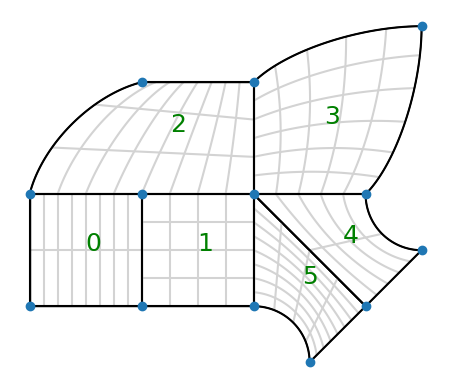

In [84]:
M.draw(knots=1, patch_idx=1, nodes=1, axis='off')
axis('scaled');

In [85]:
MP.get_crosspoints()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [88]:
loc_corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=1)+MP.N_ofs[p] for p,kvs in enumerate(kvs)])
dir_dofs = np.unique(np.concatenate([assemble.boundary_dofs(kvs[p],bdspec=[assemble.int_to_bdspec(b)],ravel=1)+MP.N_ofs[p] for p,b in MP.mesh.outer_boundaries[0]]))
node_dofs = np.setdiff1d(loc_corners,dir_dofs)

In [89]:
node_dofs

array([ 39,  70,  75,  85, 126, 182, 264])

In [90]:
print(MP.Basis[node_dofs,:])

  (0, 55)	0.5
  (0, 62)	0.5
  (1, 55)	0.5
  (1, 62)	0.5
  (2, 63)	1.0
  (3, 63)	1.0
  (4, 63)	1.0
  (5, 63)	1.0
  (6, 63)	1.0


In [ ]:
{p:[(,[])] for p in range(MP.numpatches)}

In [93]:
bspline.collocation(kvs[0][0],0.25).A

array([[0.250, 0.625, 0.125, 0.000]])

In [20]:



MP.Basis.tocsc()

<193x149 sparse matrix of type '<class 'numpy.float64'>'
	with 208 stored elements in Compressed Sparse Column format>

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)

In [43]:
kv1=bspline.KnotVector(np.array([0.0,0.3,0.6,1.0]),0)
kv2=bspline.KnotVector(np.array([0.0,0.2,0.4,0.6,0.8,1.0]),0)

In [44]:
B=bspline.prolongation(kv1,kv2)

In [45]:
B.A.T

array([[1.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 1.000, 1.000]])

In [46]:
kvs=(kv1,kv2)

In [47]:
bspline.numspans(kvs)

15

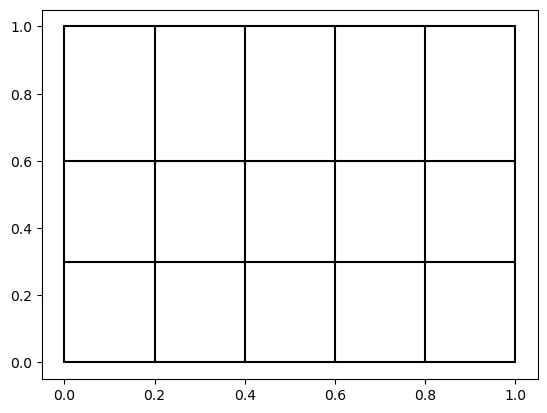

In [59]:
vis.plot_geo(geometry.unit_square(), gridx=kvs[1].mesh, gridy=kvs[0].mesh)

In [61]:
assemble.boundary_dofs(kvs, bdspec=[(0,1)], ravel=1)

array([10, 11, 12, 13, 14])

In [74]:
a={0:1}
b={0:2,3:4}

In [76]:
set(b) - set(a)

{3}

In [77]:
type('a')

str